4.haftadayız ve şimdiye kadar makine öğrenmesi adına en yoğun ders bu olacak. Kaggle anket sonuçlarını incelediğimiz yazıda söylediğim gibi piyasada en çok kulanılan yöntem hala Lojistik Regresyon, tanımı şöyle:

# Lojistik Regresyon (Logistic Regression)

“In statistics, logistic regression, or logit regression, or logit model[1] is a regression model where the dependent variable (DV) is categorical.”

Bağımlı değişkenimizin, modelini kurmak istediğimiz, tahmin etmek istediğimiz değişkenimizin tipi kategori ise Logistik Regresyon tekniğini kullanırız. Örneğin bir kişinin hasta olup olmayacağı (0–1), bir futbol maçının sonucu (0–1–2), yeni doğacak bebeğin cinsiyeti (E:0, K:1) gibi bağımlı değişkenlerimizi modellemek istiyorsak lineer regresyon bize yardım edemez.

Seyrek matris (Sparse matris)

Seyrek matrisler (Sparse matris), matristeki veri tutulan kısmın tüm matrise oranının küçük olduğu özel matrislerdir.

Bizim örneğimizde 336358x48371'lik bir matriste (16.2 milyar) değer varken sadece 3195430 değerde veri tutuluyor.

Seyrek matrislerin avantajı daha az yer kapladığı için verilerin hafızada kolayca tutulması.

Eğer bu derse ciddi bir mesai ayırırsanız Loijstik Regresyona ve seyrek matrislere ek olarak aşağıdakileri öğreneceksiniz.

-Nasıl yeni öznitelikler oluşturacağınızı

-Onlar arasından en iyilerini nasıl seçeceğinizi

-Niye ölçeklendirmeye (scaling) ihtiyaç duyduğunuzu

-Nasıl hiper-parametre seçimi yapacağınızı

-Nasıl Kaggle yarışmalarına katılacağınızı

Eğer hazırsak başlayabiliriz.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

Probleme Yaklaşım

Kişilerin internetteki davranışlarını analiz ederek izinsiz giriş problemlerini (intrusion detection problem) çözeceğiz. Bu problem veri analizi ve davranışsal psikolojinin kesiştiği karmaşık ve ilginç bir alanın konusu.

Yarışmada da benzer bir problemi çözeceğiz. Algoritmamız belirli bir kişi tarafından ziyaret edilen web sitelerini analiz edecek ve bu kişinin Ali mi yoksa izinsiz giren kişi mi olduğunu tahmin edecek. Bu tahminlerin başarı oranı için ROC AUC metriğini hesaplayacağız.

1.Veri İndirme ve Dönüşüm İşlemleri

Eğer kayıtlı değilseniz buradan Kaggle’a erişebilirsiniz. Sonrasında yarışma sayfasına buradan girip veriyi lokalinize indirebilirsiniz.

In [2]:
#Eğitim ve test verilerimizi çağırıyoruz öncelikle.
train_df = pd.read_csv('data/train_intrusion.csv',
                       index_col='session_id')
test_df = pd.read_csv('data/test_intrusion.csv',
                      index_col='session_id')

#time1, ....., time10 sütunun tipini zamansal analizler için datetime yapıyoruz. 
#Aşağıdaki ilk gösterim daha önce alışık olmadığınız bir gösterim olabilir %s yerine range'de atanan sayıların geldiği bir seri 
#oluşturuluyor. apply() fonksiyonu geçen derslerden bildiğimiz bir fonksiyon, pd.to_datetime dönüşümünü bütün time sütunları için
#yapmamıza olanak sağlıyor.

times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
#Zamana göre sıralıyoruz.
train_df = train_df.sort_values(by='time1')

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Eğitim setimizdeki öznitelikler aşağıdaki gibi:

 - site1 — oturumda ilk ziyaret edilen web sitesi
 - time1 — oturumda ilk ziyaret edilen web sitesinde ne kadar zaman geçirildiği (sn)
 - …
 - …
 - …
 - site10 — oturumda onuncu ziyaret edilen web sitesi
 - time10 — oturumda onuncu ziyaret edilen web sitesinde ne kadar zaman geçirildiği (sn)
 - target — hedef değişkenimiz hesapta Alice varsa 1 başkası varsa 0

Kullanıcı oturumları eğer oturum yarım saatten fazla sürdüyse veya ondan fazla web sitesine giriş olmuşsa kesiliyor ve o haliyle kaydediliyor.

Tablodaki boş değerler(NaN) 10'dan az web sitesine girildiği anlamına geliyor. Bu boş değerleri 0'la değiştirip sütunların tiplerini ‘integer’ yapıyoruz.

In [5]:
#Yukarıda yaptığımız dönüşümün bir benzerini burada yapıyoruz. 
#Yine sitelerden oluşan bir sites dizisi oluşturduk. Sonrasında 
#sadece sites sütunları üzerindeki NaN değerleri 0 ile değiştiriyoruz 
#ve öz nitelğin tipini integer yapıyoruz.

sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# websitelerin bulunduğu veriyi de açıyoruz.
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# sonrasında bir data frame oluşturmamız gerekiyor.
sites_dict = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


1.1. Eğitim ve Test veri setlerinin boyutları nedir?

    (82797, 20) and (253561, 20)
    (82797, 20) and (253561, 21)
    (253561, 21) and (82797, 20)
    (253561, 20) and (82797, 20)

In [6]:
print("Eğitim veri setinin boyutu {0} ".format(train_df.shape))
print("Test veri setinin boyutu {0} ".format(test_df.shape))

Eğitim veri setinin boyutu (253561, 21) 
Test veri setinin boyutu (82797, 20) 


2. Açıklayıcı Veri Analizi
2.1. Ali'nin en çok ziyaret ettiği sitelerin türü nedir?

   - videohostings
   - social networks
   - torrent trackers
   - news

#Eğitim setindeki en çok ziyaret edilen siteleri bulmak için 
yukarıdaki sorgu işimize yaramayacaktır. 
#train_df[sites]'ten itibaren bütün adımları tek tek uygulamınızı
tavsiye ederim.

In [7]:
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()).\
  value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.index.tolist()]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
0,NaN
23,www.google.com
782,annotathon.org
22,apis.google.com


In [8]:
# Eğitim setimizde her bir sitede ne kadar zaman geçirdiğimiz vardı. 
#Şimdi ise her bir oturumda ne kadar zaman geçirildiğini
#bulmak için yeni bir data frame oluşturuyoruz.
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

#np.timedelta64 içindeki 's' saniyeyi gösteriyor, dakika cinsinden 
#hesap yapmak istersek 'm'(minute) yazabiliriz.
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


2.2. Aşağıdaki ifadelerden doğru olanları seçiniz:

- Ali'nin ortalama oturum süresi diğer kullanıcıların ortalama oturum süresinden kısadır.
- Veri setindeki oturumların %1'inden fazlası Ali'ye aittir.
- Ali'nin ve diğer kullanıcıların oturumlarda harcadıkları minimum ve maksimum süre yaklaşık olarak aynıdır.
- Bütün kullanıcılar için ortalama oturum süresinin değişkenliği aynıdır.
- Ali'nin %25'lik quartile değeri 40 saniyeye eşit veya fazladır.


In [9]:
print(time_df[time_df['target'] == 1].seconds.mean() < time_df[time_df['target'] == 0].seconds.mean())
print(len(time_df[time_df['target'] == 1]) / len(time_df) > 0.01)
print(time_df[time_df['target'] == 1].seconds.min())
print(time_df[time_df['target'] == 0].seconds.min())
print(time_df[time_df['target'] == 1].seconds.max())
print(time_df[time_df['target'] == 0].seconds.max())
print(np.std(time_df.seconds, axis=0))
print(time_df[time_df['target'] == 1].seconds.quantile(0.25) > 40)

True
False
0.0
0.0
1763.0
1800.0
295.7811587477903
False


In [10]:
#İlk modelimizi eğitmek için öncelikle verimizi modele uygun olarak hazırlamalıyız. 
#İlk olarak eğitim setimizden hedef değişkenimizi çıkarıyoruz. 
#Böylelikle eğitim ve test setlerimiz eşit sayıda sütun içerecek ve bütün dönüşüm 
#işlemleri tek bir data frame'da yapılıyor gibi eş zamanlı olarak eğitim ve test 
#verilerine etki edecek.

y_train = train_df['target']

#concat fonksiyonu iki veriyi birleştiriyor. drop fonksiyonu ailk olarak atılacak sütun değerini alıyor.
#Atılacak değer satırda ise axis = 0, sütunda ise axis = 1 olarak seçiyoruz.

full_df = pd.concat([train_df.drop('target', axis=1), test_df])

#Sonraki adımlar için train sınırını kaydediyoruz.
idx_split = train_df.shape[0]

#Temel modelimiz için sadece oturum boyunca ziyaret edilen web sitelerinin 
#bulunduğu sütunları kullanacağız, süreler kullanılmayacak. 
#Diğer bir deyişle oturum boyunca Ali'nin favori sitelerine ne sıklıkla 
#girdiğini modelleme çalışıyoruz.

full_sites = full_df[sites]
full_sites.tail()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
82793,812,1039,676,0,0,0,0,0,0,0
82794,300,302,302,300,300,1222,302,1218,1221,1216
82795,29,33,35,22,37,6779,30,21,23,6780
82796,5828,23,21,804,21,3350,23,894,21,961
82797,21,1098,1098,1098,1098,1098,1098,1098,1098,1098


In [11]:
#Yukarıdaki gösterim lineer methodlar için uygun değil, dolayısıyla 
#her web sitesinin bir özniteliğe (sütun), sitelerin belirli bir 
#oturumda ziyaret edilme sayısının da değere (value) denk geldiği 
#bir dönüşüm yapmamız gerekiyor.

sites_flatten = full_sites.values.flatten()

full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]
full_sites_sparse


<336358x48371 sparse matrix of type '<class 'numpy.int64'>'
	with 3195430 stored elements in Compressed Sparse Row format>

Seyrek Matris (Sparse Matrix)

Seyrek matrisler, matristeki veri tutulan kısmın tüm matrise oranının küçük olduğu özel matrislerdir. Bizim örneğimizde 336358x48371'lik bir matriste (16.2 milyar) değer varken sadece 3195430 değerde veri tutuluyor. Seyrek matrislerin avantajı daha az yer kapladığı için verilerin hafızada kolayca tutulması.

In [12]:
# Sparse matrisler matrimizin ne kadar hafıza kapladığını iki farklı yolla bulabiliriz.
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))

print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 14935184 bytes


In [13]:
data = [1] * 9

indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

indptr = [0, 3, 6, 9]

matris = csr_matrix((data, indices, indptr)).todense()
matris

matrix([[2, 1, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 1, 1]])

In [14]:
#İlk sütun fazla olduğu için atmalıyız.
matris = np.delete(matris, 0, 1)
matris

matrix([[1, 0, 0, 0],
        [2, 0, 1, 0],
        [0, 1, 1, 1]])

4.4. Matrisimizin sparness değeri kaçtır?

    42%
    47%
    50%
    53%

Matristeki sıfır olmayan değerlerin sayısının toplam 
değerlerin sayısına bölerek matrisin sparness'ini buluyoruz.

In [15]:
np.count_nonzero(matris) / 12

0.5

3.İlk modelimizi eğitme

İlk modelimiz için sklearn default değerleriyle lojistik regresyon kullanıyoruz.Verimizin %90'ını eğitim %10'unu validasyon için kullanıyoruz.

In [16]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    
    #NOT: X herhangi bir değer olabilir örneğimizde X_train kullanacağımız 
    #için şimdiden açıklamaları öyle yazdım.
    
    #X_train verisinin satır sayısıyla 0.9 sınır değerimizi çarpıp idx 
    #sınır değerini buluyoruz.
    idx = int(round(X.shape[0] * ratio))
    
    #X_train verimizin yukarıda koyduğumuz %90'luk kısmıyla verimizi eğitiyoruz. 
    lr = LogisticRegression(C=C, random_state=seed).fit(X[:idx, :], y[:idx])
    
    #kalan %10'lık veri setiyle tahminde bulunuyoruz.
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    
    #tahmin ettiğimiz değerlerle gerçek y değerlerinin başarı oranına bakmak 
    #için roc auc skorunu kullanıyoruz.
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [17]:
%%time

#X_train matrisini bulmak için sparse matrimizi dersin başiındaki 
#idx_split sınırıyla bölüyoruz. 
X_train = full_sites_sparse[:idx_split, :]

print(get_auc_lr_valid(X_train, y_train))

0.919523954876358
CPU times: user 1min 16s, sys: 4.71 s, total: 1min 21s
Wall time: 4.28 s


İlk modelimiz validasyon seti üzerinde 0.91952 doğruluk oranınına sahip oldu. 
Burası daha bizim başlangıç noktamız. Test veri seti üzerinde tahmin yapmak 
için modelimizi tüm eğitim seti üzerinde tekrar eğitmemiz gerekiyor. 
Şimdiye kadar modelimiz eğitim için verinin sadece bir kısmını kullandı, 
hepsini kullandığımızda modelimizin gücü artacak.

In [18]:
# Tahminleri bir dosyaya yazmak için aşağıdaki fonksiyonu kullanabiliriz.
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
# Modeli bütün eğitim setini kullanarak eğitiyoruz.
# Tekrar kullanımlara imkan sağlamak için  random_state=17 seçiyoruz.
# Parameter C=1 default olarak veriliyor, biz burada sadece görünür yaptık.

lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)

# Test veri seti için tahmin yapıyoruz.
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Sonuçları bir csv dosyasına yazdırıyoruz.
write_to_submission_file(y_test, 'baseline_1.csv')

#Yukarıdaki adımları takip edip csv dosyasını yarışma sayfasına 
#yüklediyseniz ROC AUC = 0.90812 olmalı.

## 4.Modeli Geliştirme: Öznitelik Mühendisliği
- 4.1.Eğitim ve test veri setlerinde hangi yıllardaki veriler bulunmaktadır?

   - 13 and 14
   - 2012 and 2013
   - 2013 and 2014
   - 2014 and 2015

In [19]:
full_df[:idx_split].head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT


In [20]:
full_df[idx_split:].tail(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
82796,5828,2014-05-03 10:05:25,23,2014-05-03 10:05:27,21,2014-05-03 10:05:27,804,2014-05-03 10:05:27,21,2014-05-03 10:05:36,3350,2014-05-03 10:05:37,23,2014-05-03 10:05:37,894,2014-05-03 10:05:38,21,2014-05-03 10:05:38,961,2014-05-03 10:05:38
82797,21,2014-11-02 10:46:57,1098,2014-11-02 10:46:57,1098,2014-11-02 10:46:58,1098,2014-11-02 10:47:12,1098,2014-11-02 10:47:13,1098,2014-11-02 10:47:14,1098,2014-11-02 10:47:15,1098,2014-11-02 10:47:18,1098,2014-11-02 10:47:42,1098,2014-11-02 10:47:47


In [21]:
#Şimdi de YYYYMM formatında yeni bir öznitelik çıkaracağız. 
#Örneğin 2014 yılının 7. ayı 201407 olarak gözükecek.

full_new_feat = pd.DataFrame(index=full_df.index)

#lambda x (ts) fonksiyonuna aşinayız artık.
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

4.2. Ali'nin oturumları ve yeni öznitelik 'start_month' ile 
ilgili aşağıdaki ifadelerden doğru olanları seçmemiz isteniyor.

    Ali her ay online olarak görüldü.
    2013 başından 2014 ortasına kadar, Ali aylık oturum sayısı azaldı.
    Bütün süreçte Ali'nin aylık oturum sayısı genel olarak sabitti.
    2013 başından 2014 ortasına kadar, Ali aylık oturum sayısı arttı.

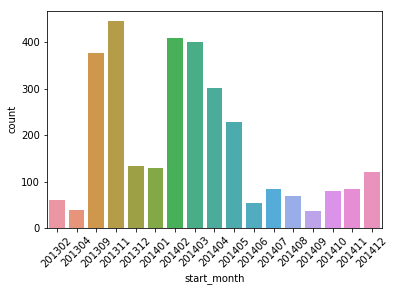

In [22]:
ali_index = time_df[time_df.target == 1].index
import seaborn as sns
sns.countplot(full_new_feat.loc[ali_index]['start_month'])
plt.xticks(rotation=45)
plt.show()

In [23]:
# yeni özniteliğimizi de sparse matrise ekleyelim.
month = full_new_feat[['start_month']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], month[:idx_split,:]]))

# Validasyon seti üzerinde tahmin sonuçlarımıza bakalım.
print(round(get_auc_lr_valid(X_train, y_train), 4))

0.7508


Modelimizin başarı oranı ciddi bir şekilde düştü. Faydalı bir öznitelik eklediğimizi düşünmemize rağmen modelimiz niye bu kadar kötü bir sonuç verdi?

Öznitelikleri ölçeklendirmek (Scaling) gerekli mi?

Her oturumda belirli bir web sitesine yapılan ziyaret sayısı 0 ile 10 değerlerini alırken ‘start_month’ özniteliği 201301 ile 201412 arasında değerler alıyor. Bu da demektir ki bu öznitelik modeli diğerlerinden çok daha fazla etkileyecektir. Bu sebeple öznitelikleri aynı aralığa (scale) çekmemiz gerekiyor. Regularization ile ilgili ayrıntılı bilgiye buradan ulaşabilirsiniz.

Standartlaştırmanın bir yöntemi şöyle: Her gözlem değerini ait olduğu özniteliğin ortalama değerinden çıkartıp standart sapmasına bölebiliriz.

Bazı pratik tavsiyeler:

- Eğer özniteliklerimizin değerleri arasındaki fark çok fazlaysa ölçeklendirme mantıklı. (Örneğin, ülke nüfus değerleri milyon cinsindeyken GNP değerleri trilyon cinsindense.)
- Eğer özniteliklerden bazılarına fazla ağırlık vermek konusunda herhangi bir nedenimiz veya fikrimiz yoksa ölçeklendirme mantıklı.
- Eğer modelimizi açıklamak istiyorsak, modelimizi düzenleştirmeden (regularization) ve ölçeklendirmeden (scaling) yapmanız faydalı.
- Ama esas olan modelimizin başarı oranını arttırmak ise farklı seçenekler deneyip en iyi performansı gösteren modeli seçmeliyiz.
- Şimdi ‘start_month’ özniteliğini ölçeklendirelim modeli eğitmek için tekrar kullanalım ve başarı oranına bakalım.

In [24]:
# yeni özniteliğimizin standartlaştırılmış halini sparse matrisimize ekliyoruz.
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# validasyon seti üzerinde metriğimizi tekrar hesaplıyoruz.
print(round(get_auc_lr_valid(X_train, y_train), 4))

0.9197


4.3. Eğitim setimize "n_unique_sites" diye bir öznitelik ekleyip 
validasyon seti üzerinde başarı oranına bakacağız.
"n_unique_sites" özniteliği bir oturum boyunca girilen unique 
web-sitelerinin sayısını bize veriyor.

In [25]:
train_df['unique_count'] = train_df[sites].nunique(axis=1) - 1
full_new_feat['unique'] = train_df['unique_count']

In [26]:
# yeni özniteliğimizin standartlaştırılmış halini sparse matrisimize ekliyoruz.
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
tnw = StandardScaler().fit_transform(full_new_feat[['unique']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], 
                             tnw[:idx_split,:]]))

# validasyon seti üzerinde metriğimizi tekrar hesaplıyoruz.
print(round(get_auc_lr_valid(X_train, y_train), 4))

0.9157


Yeni öznitelik modelimizin başarı metriğini biraz azalttı, 
bu yüzden son modeli kullanmayacağız ama bu öznitelikleri 
tamamen atmıyoruz. Sonraki süreçte yeni özniteliklerle bir 
uyum halinde modelin başarı oranını arttırabilir.
4.8. start_hour and morning diye iki öznitelik ekleyip 
modelimizin başarı oranını arttırıp artırmadığına bakacağız.

Saat 0-11(dahil) olduğunda sabah diyoruz.

In [27]:
train_df['Date/Time'] = pd.to_datetime(train_df[times]['time1'], 
                                       format='%Y-%m-%d %H:%M:%S')
train_df['HourofDay'] = train_df['Date/Time'].dt.hour
train_df['is_morning'] = np.where(train_df['HourofDay'] >= 11, 1,0)
full_new_feat['start_hour'] = train_df['HourofDay']
full_new_feat['morning'] = train_df['is_morning']

# yeni özniteliğimizin standartlaştırılmış halini sparse matrisimize ekliyoruz.
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
tnw = StandardScaler().fit_transform(full_new_feat[['unique']])
tns = StandardScaler().fit_transform(full_new_feat[['start_hour']])
tnm = StandardScaler().fit_transform(full_new_feat[['morning']])

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], 
                             tnw[:idx_split,:], 
                            tns[:idx_split,:], tnm[:idx_split,:]]))
# validasyon seti üzerinde metriğimizi tekrar hesaplıyoruz.
print(round(get_auc_lr_valid(X_train, y_train), 4))

0.9542


In [28]:
# yeni özniteliğimizin standartlaştırılmış halini sparse matrisimize ekliyoruz.
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
tns = StandardScaler().fit_transform(full_new_feat[['start_hour']])
tnm = StandardScaler().fit_transform(full_new_feat[['morning']])

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], 
                            tns[:idx_split,:], tnm[:idx_split,:]]))

# validasyon seti üzerinde metriğimizi tekrar hesaplıyoruz.
print(round(get_auc_lr_valid(X_train, y_train), 4))

0.9585


## 5.Düzenlileştirilmiş (Regularization) Parametre Seçimi (Parameter Tuning)

İlk modelimizle kıyasla modelimizin kalitesini arttıracak yeni öznitelikler çıkardık. Peki daha iyisini yapabilir miyiz? Eğitim ve test veri setlerimizi oluşturduktan sonra optimal hiper parametreleri (eğitim süresince değişmeyen model paramatreleri) aramak mantıklı.

Örneğin 3. haftada karar ağaçlarına baktığımızda, ağacın derinliği bir hiper parametreydi ama ayrımı oluşturan öznitelikler ve onun sınırı bir hiper parametre değildi.

Kullandığımız lojistik regresyonda, her bir özniteliğin ağırlığı değişiyor ve biz eğitme süresince onların optimal değerlerini bulurken düzenlileştirme (regularization) parametreleri sabit kalıyor. Şimdi bu hiper parametreleri optimize edeceğiz.

Düzenlileştirme parametresiyle (default değeri 1) birlikte validasyon seti üzerinde modelin kalitesini hesaplayacağız.

Düzenlileştirme parametresini optimize ederek yukarıdaki sonuçtan daha iyi bir sonuç elde etme istiyoruz. Bundan dolayı validasyon seti üzerinde C’nin her olası değeri için elde edilen ROC_AUC değerine bakacağız.

In [31]:
%%time

Cs = np.logspace(-3, 1, 10)

scores = []
    
for C in Cs:
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))


from tqdm import tqdm
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 10/10 [00:29<00:00,  2.99s/it]

CPU times: user 18min 27s, sys: 1min 4s, total: 19min 31s
Wall time: 58.7 s


Metriğimiz (AUC-ROC) y ekseninde düzenlileştirme parametremiz (C) x ekseninde 
olacak şekilde grafiğimizi çiziyoruz. Default olarak gelen C = 1 değerinde 
modelin AUC-ROC değeri yatay çizgiyle gösteriliyor.

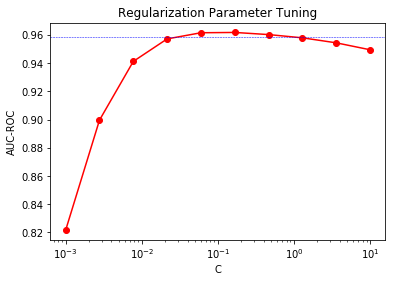

In [32]:
score_C_1 = 0.9585
plt.plot(Cs, scores[:10], 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

5.1. Modele en yüksek değere ulaştıran C parametresi kaçtır?

    0.17
    0.46
    1.29
    3.14

In [33]:
C = 0.17

# Eğitim ve test setlerimizi hazırlayıp alışkın olduğumuz süreçleri başlatıyoruz.
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Modeli bütün eğitim setiyle eğitiyoruz ve bu sefer optimal düzenlileştirme değerlerini kullanıyoruz.
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)

# Test verisi üzerinde tahmin yapıyoruz.
y_test = lr.predict_proba(X_test)[:, 1]

# Ve tahminlerimizi kaydediyoruz.
write_to_submission_file(y_test, 'baseline_2.csv')

Bu ödevde, sparse matrisleri nasıl kullanacağımızı, lojistik regresyon modellerini nasıl eğiteceğimizi, nasıl yeni öznitelikler oluşturup onlar arasından en iyilerini nasıl seçeceğimizi. Ayrıca niye ölçeklendirmeye (scaling) ihtiyaç duyduğumuzu ve nasıl hiper parametre seçimi yapacağımızı öğrendik.

Yeni öznitelikler bulmak için birkaç ipucu:

- Hali hazırda varolan özniteliklerle ne yapacağınızı düşünün, bunları toplayın, çıkarın, çarpın, bölün vs.
- Zaman serisi verilerinden yeni bilgiler çıkarmaya çalışın. (Örneğimizde veriden saati saatten de sabah mı değil mi özniteliğini çıkarıp modeli bu yeni bilgilerle eğittik.
- Varolan özniteliklerin logunu, karesini vs. alıp farklı öznitelikler çıkarmaya çalışın.
- Sürekli yeni fikirler ve modeller deneyin.
- Dersteki kodlara buradan ulaşabilirsiniz, keyifli çalışmalar.

# “Models are opinions embedded in mathematics” — Cathy O’Neil